## Imports and Environment Variables

In [7]:
import os
from dotenv import load_dotenv

In [8]:
# Load environment variables
load_dotenv()

SUBSCRIPTION_ID = os.getenv('SUBSCRIPTION_ID')

## Feature Engineering

In [9]:
import pandas as pd

# Read the data
df = pd.read_csv('src/data/train.csv', index_col=0)

In [10]:
# Explore the data
print(df.dtypes)
df.sample(10)


Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
3315039,Female,28,1,10.0,0,< 1 Year,Yes,35249.0,124.0,167,0
8702519,Male,27,1,29.0,1,< 1 Year,No,31443.0,152.0,175,0
5013808,Male,77,1,28.0,0,1-2 Year,Yes,47470.0,124.0,157,0
8912731,Male,62,1,28.0,0,1-2 Year,Yes,35681.0,124.0,157,0
5336176,Female,22,1,45.0,1,< 1 Year,No,47865.0,152.0,102,0
5845458,Male,54,1,41.0,0,1-2 Year,Yes,43378.0,26.0,49,1
6784005,Female,50,1,41.0,0,1-2 Year,Yes,38986.0,26.0,68,0
8363408,Female,27,1,28.0,0,< 1 Year,Yes,66576.0,152.0,37,0
10583318,Female,70,1,36.0,1,1-2 Year,No,2630.0,160.0,206,0


## Generate training scripts

In [11]:
# create a folder for the script files
script_folder = 'src'
os.makedirs(script_folder, exist_ok=True)
print(script_folder, 'folder created')

src folder created


In [15]:
%%writefile $script_folder/train.py
# Import libraries
import argparse
import mlflow
import datetime
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import roc_auc_score
from tensorflow.keras import layers, models, optimizers, metrics

def parse_args():
    
    # Parse arguments
    parser = argparse.ArgumentParser()
    parser.add_argument("--train-data", dest="train_data", type=str, required=True)
    parser.add_argument("--test-data", dest="test_data", type=str, required=True)
    args = parser.parse_args()
    
    return args

def main(args):
    
    mlflow.set_experiment("Insurance-CrossSell-Prediction")
    mlflow.sklearn.autolog(silent=True)
    mlflow.keras.autolog(silent=True)
    
    print("Reading data...")
    train_df = read_data(args.train_data)
    test_df = read_data(args.test_data)
    
    print("Balancing data based on labels...")
    train_df = balance_data(train_df)
    
    categorical_columns = ["Gender", "Vehicle_Age", "Vehicle_Damage"]
    numerical_columns = ["Age", "Annual_Premium","Policy_Sales_Channel", "Vintage", "Region_Code"]
    
    print("Preprocessing data and applying encoding to categorical columns...")

    # Apply ordinal encoding to categorical columns
    for col in categorical_columns:
        encoder = OrdinalEncoder()
        train_df[col] = encoder.fit_transform(train_df[col].values.reshape(-1,1))
        test_df[col] = encoder.transform(test_df[col].values.reshape(-1,1))
    
    # Normalize the data
    for col in numerical_columns:
        scaler = StandardScaler()
        train_df[col] = scaler.fit_transform(train_df[col].values.reshape(-1,1))
        test_df[col] = scaler.transform(test_df[col].values.reshape(-1,1))
        
    # Save test data after preprocessing
    test_df.to_csv("data/test_preprocessed.csv")
    
    X_train = train_df.drop('Response', axis=1)
    y_train = train_df['Response']
    
    # Split the data for validation
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.7, random_state=42)

    # Train using logistic regression
    regularization_rate = 0.1
    solver = 'liblinear'
    with mlflow.start_run(run_name=get_friendly_run_id("LogisticRegression_sag")):
        model = train_logistic_regression_model(X_train, y_train, regularization_rate, solver)
        evaluate_model(model, X_test, y_test)
    
    # Train using Random Forest
    n_estimators = 100
    criterion = 'gini'
    with mlflow.start_run(run_name=get_friendly_run_id("RandomForestClassifier")):
        model = train_random_forest_model(X_train, y_train, n_estimators, criterion)
        evaluate_model(model, X_test, y_test)
        
    # Train using Neural Network
    # Define the K-fold Cross Validator
    num_folds = 5
    kfold = KFold(n_splits=num_folds, shuffle=True)
    fold_no = 1
    
    X_train = train_df.drop('Response', axis=1)
    y_train = train_df['Response']
    
    for train, test in kfold.split(X_train, y_train):
        X_train_kf, X_test_kf = X_train.iloc[train], X_train.iloc[test]
        y_train_kf, y_test_kf = y_train.iloc[train], y_train.iloc[test]
        
        input_shape = X_train_kf.shape[1]
        epochs = 10
        batch_size = 64
        print(f"Training fold {fold_no}...")
        with mlflow.start_run(run_name=get_friendly_run_id(f"NeuralNetwork_Fold_{fold_no}")):
            model = train_neural_network_model(X_train_kf, y_train_kf, input_shape, epochs, batch_size)
            evaluate_neural_network(model, X_test_kf, y_test_kf) 
    
        fold_no = fold_no + 1    
    
def train_logistic_regression_model(X_train, y_train, reg_rate, solver):
    print("Traning LogisticRegression model...")
    model = LogisticRegression(solver=solver, C=1/reg_rate, random_state=42)
    model.fit(X_train, y_train)
    return model

def train_random_forest_model(X_train, y_train, n_estimators, criterion):
    print("Traning RandomForestClassifier model...")
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=42, criterion=criterion)
    model.fit(X_train, y_train)
    return model

def train_neural_network_model(X_train, y_train, input_shape, epochs, batch_size):
    print("Traning NeuralNetwork model...")
    print("Input shape:", input_shape)
    
    model = models.Sequential()
    model.add(layers.Dense(256, activation='relu', input_shape=(input_shape,)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), 
                  loss='binary_crossentropy', 
                  metrics=[metrics.BinaryAccuracy(name="training_accuracy_score"), metrics.AUC(name="training_roc_auc"), metrics.Precision(name="training_precision"), metrics.Recall(name="training_recall"), metrics.F1Score(name="training_f1_score")])
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
    
    return model

def evaluate_model(model, X_test, y_test):
    print(f"Evaluating model...")
    
    predictions = model.predict(X_test)
    accuracy = np.average(y_test == predictions)
    print("Accuracy:", accuracy)
    mlflow.log_metric("evaluation_accuracy_score", accuracy)
    
    y_scores = model.predict_proba(X_test)
    auc = roc_auc_score(y_test, y_scores[:,1])
    print("AUC:", auc)
    mlflow.log_metric("evaluation_roc_auc_score", auc)
    print("*" * 30)
    
def evaluate_neural_network(model, X_test, y_test):
    print(f"Evaluating model...")
    
    score = model.evaluate(X_test, y_test)
    print(score)
    
    print("Accuracy:", score[1])
    mlflow.log_metric("evaluation_accuracy_score", score[1])
    
    print("AUC:", score[2])
    mlflow.log_metric("evaluation_roc_auc_score", score[2])
    print("*" * 30)
    
def get_friendly_run_id(model_name = None):
    now = datetime.datetime.now()
    if(model_name):
        return now.strftime(f"%Y_%m_%d_%H_%M_%S-{model_name}")
    
    return now.strftime("%Y_%m_%d_%H_%M_%S")

def read_data(data_path):
    # Read data
    data = pd.read_csv(data_path, index_col=0)
    return data

def balance_data(data):
    # Level label samples
    # Pick random sample data from train data where column Response is 0
    false_rows = data[data['Response'] == 0].sample(frac=0.14, random_state=42)
    true_rows = data[data['Response'] == 1]

    # Concatenate the false_rows and true_rows
    data = pd.concat([false_rows, true_rows])
    
    return data

if __name__ == "__main__":
    
    print("\n")
    print("*" * 60)

    args = parse_args()
    main(args)
    
    print("*" * 60)
    print("\n")

Overwriting src/train.py


## Read model using MLFlow

In [20]:
import mlflow

# Get current execution folder
current_folder = os.getcwd()

# Set the MLflow tracking URI to a specific folder
mlflow.set_tracking_uri(f"file:///{current_folder}/src/mlruns")

# Read the best model by using MLflow ordered by specific metric
runs = mlflow.search_runs(order_by=["metrics.evaluation_roc_auc_score DESC"], search_all_experiments=True)

# Get the best run ID
best_run_id = runs.iloc[0]["run_id"]
print(f"Loading model from best run ID: {best_run_id}")
# Import the model and load it
model = mlflow.keras.load_model(f"runs:/{best_run_id}/model")
#model = mlflow.sklearn.load_model(f"runs:/c67fb91d0d714ba1a03192c6b9591e58/model")

Loading model from best run ID: 1b6b5a5c4e9f4009a424c339ebc16258


## Test the model and generate output artifact

In [21]:
import pandas as pd

print("Reading test data...")
test_df = pd.read_csv("src/data/test_preprocessed.csv")

test_df["Response"] = model.predict(test_df.drop('id', axis=1))

test_df["Response"] = test_df["Response"].apply(lambda x: 1 if x > 0.5 else 0)

test_df[['id', 'Response']].to_csv("src/data/submission_data.csv", index=False)

Reading test data...


## Conclusions

The best performing model was the neural network with the score **0.80246**.  The random forest classificator got **0.78873**

--> **Note**: Always take into account the labels balance in the training data

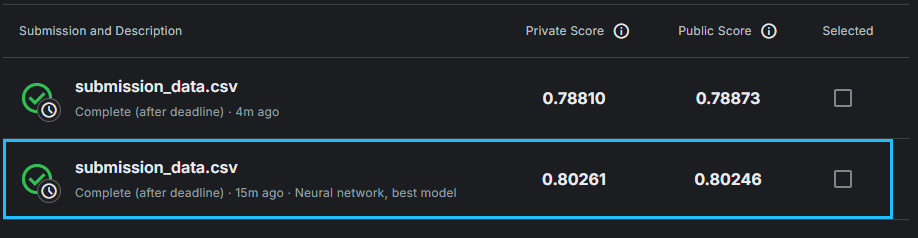